<a href="https://colab.research.google.com/github/unicamp-dl/IA025_2022S1/blob/main/ex06/Gabriel_Lopes/Aula_6_Exerc%C3%ADcio_Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Treinamento de uma CNN no CIFAR 10

In [9]:
nome = 'Gabriel Victor de Sousa Lopes'

print(f'Meu nome é {nome}')

Meu nome é Gabriel Victor de Sousa Lopes


Este exercicío consiste em implementar e treinar no CIFAR-10 vários blocos de uma Resnet seguido de uma camada linear de classificação.

## Importação das bibliotecas

In [10]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

## Fixando as seeds

In [11]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

## Dataset e dataloader

### Definição do tamanho do minibatch

In [12]:
batch_size = 50

## Download do CIFAR-10

In [13]:
!mkdir ./data

transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)


mkdir: cannot create directory ‘./data’: File exists
Files already downloaded and verified
Files already downloaded and verified


## Criação do dataloader

In [14]:
train_size = 40000
val_size = 10000
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [15]:
batch_size = 50

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print('Número de minibatches de trenamento:', len(train_dataloader))
print('Número de minibatches de validação:', len(val_dataloader))
print('Número de minibatches de teste:', len(test_dataloader))

x_train, y_train = next(iter(train_dataloader))
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))

Número de minibatches de trenamento: 800
Número de minibatches de validação: 200
Número de minibatches de teste: 200

Dimensões dos dados de um minibatch: torch.Size([50, 3, 32, 32])
Valores mínimo e máximo dos pixels:  tensor(-1.) tensor(1.)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


## Implementando o Bloco Básico da Resnet

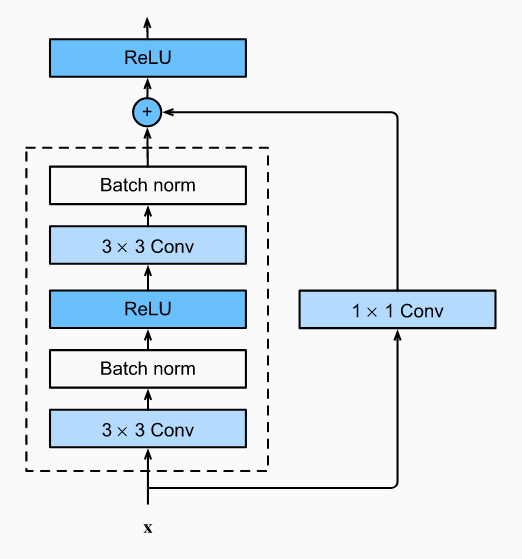

In [101]:
from torch import nn
from torch import Tensor
from collections import OrderedDict

class MyBasicBlock(nn.Module):

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
    ) -> None:
        super().__init__()
        # Escreva seu código aqui.

        self.conv1 = nn.Conv2d(inplanes,planes, kernel_size=(3, 3),padding=1, stride=stride,dilation=1,bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(planes,planes, kernel_size=(3, 3),padding=1,stride=1,dilation=1,bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
            
        self.downsample = nn.Conv2d(inplanes, planes, kernel_size=(1,1), stride=stride, padding=0, groups=1, bias=False, dilation=1)     

    def forward(self, x: Tensor) -> Tensor:
        # Escreva seu código aqui.

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        identity = self.downsample(x)     
        out += identity
        out = self.relu(out)

        return out

## Compare se sua implementação está igual à do pytorch usando um exemplo aleatório

In [102]:
import torchvision

height_in = 5
width_in = 5
inplanes = 2
planes = 3
stride = 2

x = torch.rand(1, inplanes, height_in, width_in)

block = MyBasicBlock(inplanes=inplanes, planes=planes, stride=stride)

downsample = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, padding=0, groups=1, bias=False, dilation=1)

block_pt = torchvision.models.resnet.BasicBlock(inplanes=inplanes, planes=planes, stride=stride, downsample=downsample)

# Usa os mesmos pesos para minha implementação e a do pytorch
block.load_state_dict(block_pt.state_dict())

out = block(x)
target_out = block_pt(x)

print(f'out:\n{out}')
print(f'target_out:\n{target_out}')

assert torch.allclose(out, target_out, atol=1e-6)

out:
tensor([[[[0.0000, 0.0000, 0.0000],
          [1.8274, 0.0000, 0.0908],
          [0.0000, 0.0000, 0.1126]],

         [[0.3682, 0.0000, 1.1377],
          [1.5842, 0.1367, 0.4011],
          [1.0333, 0.3690, 0.0000]],

         [[1.4060, 0.0000, 1.8877],
          [1.5012, 0.3685, 0.9354],
          [1.3747, 0.0000, 0.0000]]]], grad_fn=<ReluBackward0>)
target_out:
tensor([[[[0.0000, 0.0000, 0.0000],
          [1.8274, 0.0000, 0.0908],
          [0.0000, 0.0000, 0.1126]],

         [[0.3682, 0.0000, 1.1377],
          [1.5842, 0.1367, 0.4011],
          [1.0333, 0.3690, 0.0000]],

         [[1.4060, 0.0000, 1.8877],
          [1.5012, 0.3685, 0.9354],
          [1.3747, 0.0000, 0.0000]]]], grad_fn=<ReluBackward0>)


## Modelo

Implemente um modelo de classificação que será treinado no CIFAR-10.

In [114]:
class Net(torch.nn.Module):
    def __init__(self, ):
        super(Net, self).__init__()
        self.dense_len = 64*4*4
        self.features = nn.Sequential(OrderedDict([                                    
            ('block1', MyBasicBlock(inplanes=3, planes=32, stride=2)), 
            ('block2',MyBasicBlock(inplanes=32, planes=64, stride=2)),
            ('avg_pool1', nn.AvgPool2d(2, stride=2)), 
            ]))
        
        self.Dense = nn.Sequential(
          # camada densa
          nn.Linear(in_features=self.dense_len, out_features=128),
          nn.ReLU(),
          nn.Dropout(p=0.5),
          # camada densa
          nn.Linear(in_features=128, out_features=10),
          )

    def forward(self, x):
        # Escreva seu código aqui.
        out = self.features(x)
        out = out.view(-1, self.dense_len)
        out = self.Dense(out)
        return out

## Treinamento

### Definição dos hiperparâmetros

In [115]:
n_epochs = 20
lr = 0.01

### Detectando a GPU

In [116]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [117]:
@torch.no_grad()
def evaluation(model, loader):

    model.eval()

    valid_loss = 0.0
    acertos, total = 0, 0

    for step, (images, labels) in enumerate(loader):
        images = images.to(device)
        labels = labels.to(device)

        outptus = model(images)
        
        _, predicted = torch.max(outptus.data, 1)
        total += labels.size(0)
        acertos += (predicted == labels).sum().item()

    mean_accuracy = acertos/total  
    print(f'Accuracy: {mean_accuracy}')
    

### Laço de treinamento

In [118]:
from tqdm import tqdm


model = Net()

model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr)

epochs = []
loss_history = []
loss_epoch_end = []
total_trained_samples = 0

# Primeira avaliação com pesos aleatórios
evaluation(model=model, loader=val_dataloader)

for i in range(n_epochs):
    model.train()
    for x_train, y_train in tqdm(train_dataloader, total=len(train_dataloader), desc='Training'):
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        # predict da rede
        outputs = model(x_train)

        # calcula a perda
        loss = criterion(outputs, y_train)

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_trained_samples += x_train.size(0)
        epochs.append(total_trained_samples / len(train_dataset))
        loss_history.append(loss.item())

    loss_epoch_end.append(loss.item())
    print(f'Epoch: {i:d}/{n_epochs - 1:d} Loss: {loss.item()}')

    # Chama a função de validação no final de cada época
    evaluation(model=model, loader=val_dataloader)

Accuracy: 0.1061


Training: 100%|██████████| 800/800 [00:11<00:00, 70.58it/s]


Epoch: 0/19 Loss: 1.6008377075195312
Accuracy: 0.4516


Training: 100%|██████████| 800/800 [00:11<00:00, 70.87it/s]


Epoch: 1/19 Loss: 1.6099867820739746
Accuracy: 0.5177


Training: 100%|██████████| 800/800 [00:11<00:00, 71.24it/s]


Epoch: 2/19 Loss: 1.3595165014266968
Accuracy: 0.5553


Training: 100%|██████████| 800/800 [00:11<00:00, 70.52it/s]


Epoch: 3/19 Loss: 1.333263874053955
Accuracy: 0.5925


Training: 100%|██████████| 800/800 [00:11<00:00, 70.60it/s]


Epoch: 4/19 Loss: 1.1628459692001343
Accuracy: 0.6243


Training: 100%|██████████| 800/800 [00:11<00:00, 70.92it/s]


Epoch: 5/19 Loss: 1.1867871284484863
Accuracy: 0.6474


Training: 100%|██████████| 800/800 [00:11<00:00, 71.71it/s]


Epoch: 6/19 Loss: 1.0795975923538208
Accuracy: 0.6646


Training: 100%|██████████| 800/800 [00:11<00:00, 71.39it/s]


Epoch: 7/19 Loss: 0.9940814971923828
Accuracy: 0.6507


Training: 100%|██████████| 800/800 [00:11<00:00, 71.65it/s]


Epoch: 8/19 Loss: 1.1354988813400269
Accuracy: 0.6773


Training: 100%|██████████| 800/800 [00:11<00:00, 71.14it/s]


Epoch: 9/19 Loss: 0.7710573077201843
Accuracy: 0.703


Training: 100%|██████████| 800/800 [00:11<00:00, 69.94it/s]


Epoch: 10/19 Loss: 0.696349024772644
Accuracy: 0.7114


Training: 100%|██████████| 800/800 [00:11<00:00, 67.17it/s]


Epoch: 11/19 Loss: 0.9344920516014099
Accuracy: 0.7034


Training: 100%|██████████| 800/800 [00:12<00:00, 66.16it/s]


Epoch: 12/19 Loss: 0.6970287561416626
Accuracy: 0.7095


Training: 100%|██████████| 800/800 [00:11<00:00, 69.80it/s]


Epoch: 13/19 Loss: 0.5691589713096619
Accuracy: 0.7199


Training: 100%|██████████| 800/800 [00:11<00:00, 70.93it/s]


Epoch: 14/19 Loss: 0.8866426348686218
Accuracy: 0.7134


Training: 100%|██████████| 800/800 [00:11<00:00, 70.49it/s]


Epoch: 15/19 Loss: 0.609896719455719
Accuracy: 0.732


Training: 100%|██████████| 800/800 [00:12<00:00, 64.18it/s]


Epoch: 16/19 Loss: 0.4753709137439728
Accuracy: 0.7386


Training: 100%|██████████| 800/800 [00:11<00:00, 67.71it/s]


Epoch: 17/19 Loss: 0.6467149257659912
Accuracy: 0.7031


Training: 100%|██████████| 800/800 [00:11<00:00, 68.12it/s]


Epoch: 18/19 Loss: 0.8525328040122986
Accuracy: 0.7304


Training: 100%|██████████| 800/800 [00:11<00:00, 68.74it/s]


Epoch: 19/19 Loss: 0.4043392837047577
Accuracy: 0.7403


### Visualização usual da perda, somente no final de cada minibatch

Text(0.5, 0, 'época')

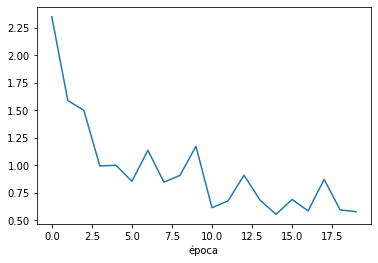

In [119]:
n_batches_train = len(train_dataloader)
plt.plot(epochs[::n_batches_train], loss_history[::n_batches_train])
plt.xlabel('época')

## Avaliação final no dataset de testes

In [120]:
evaluation(model=model, loader=test_dataloader)

Accuracy: 0.7346


# Bonus Opcional

## Implementando o Dropout

In [ ]:
class MyDropout(torch.nn.Module):
    def __init__(self, p: float):
        # Escreva seu código aqui.

    def forward(self, x: Tensor, training: bool):
        # Escreva seu código aqui.
        return out

## Mostre que sua implementação traz resultados semelhantes à implementação do pytorch

In [ ]:
import math

p = 0.5
dropout = MyDropout(p=p)

x = torch.rand(16, 3, 32, 32)

out = dropout(x, training=True)
out_pt = torch.nn.functional.dropout(x, p=p, training=True)

mean_zeros = (out == 0).sum() / out.numel()
mean_zeros_pt = (out_pt == 0).sum() / out_pt.numel()

print(f'mean zeros: {mean_zeros}')
print(f'mean zeros pytorch: {mean_zeros_pt}')

assert math.isclose(mean_zeros, mean_zeros_pt, abs_tol=1e-2)

out = dropout(x, training=False)
target_out = torch.nn.functional.dropout(x, p=p, training=False, inplace=False)
assert torch.allclose(out, target_out, atol=1e-6)